In [106]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.feature_selection import RFE

from sklearn.feature_selection import mutual_info_regression


# Fáza 2 - Predspracovanie údajov

## 2.1 Realizácia predspracovania dát

### A - Rozdelenia dát na trénovaciu a testovaciu množinu

#### zlúčime potrebné dáta do jedného datasetu 

In [108]:
# loading datasets
df_processes    = pd.read_csv("data/raw/processes.csv", sep='\t')
df_connections  = pd.read_csv("data/raw/connections.csv", sep='\t')

#### vyberieme si dáta, ktoré sme identifikovali v EDA

In [109]:
df_processes    = df_processes[["imei", "ts", "mwra", "p.android.gm", "p.android.documentsui", "p.system", "p.android.externalstorage", "p.android.settings", "p.android.chrome"]]
df_connections  = df_connections[["imei", "ts", "mwra", "c.katana", "c.dogalize", "c.android.chrome", "c.android.gm"]]

#### spojíme ich pomocou "ts" a "imei"

In [110]:
df = df_connections.merge(df_processes, on=['imei', 'ts'], how='outer')

#### Rozdelíme dáta v pomere 80:20 (trénovacia/testovacia množina). Tento pomer vychádza z predpokladu, že pri dostatočne veľkom množstve dát, máme pri rozdelení dostatok dát na trénovanie a efektívne učenie modelu, zatiaľ čo testovacia množina bude dostatočne veľká pre overenie modelu. Tento pomer je bežný a vhodný pre väčšinu úloh strojového učenia.

In [111]:
TRAIN = 0.8

train_df, test_df = train_test_split(df, train_size=TRAIN, random_state=42)

train_df.head()

,imei,ts,mwra_x,c.katana,c.dogalize,c.android.chrome,c.android.gm,mwra_y,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,3590433799317662410,2018-05-08 05:47:00,1.0,7.37476,6.84145,14.51324,8.56085,1.0,10.00362,14.20752,4.78716,10.20058,12.70029,8.13225
12572,8630330696303481594,2018-05-13 20:05:00,1.0,7.58574,12.51114,10.92101,15.39765,1.0,11.05524,8.31027,13.02334,11.10510,7.75706,13.55727
12930,359043379931766650,2018-05-14 02:00:00,0.0,11.17412,12.19228,7.55783,4.73609,0.0,9.57015,7.87946,6.44430,8.62500,4.71937,9.00245
14497,3590433799317661156,2018-05-15 03:13:00,0.0,12.71124,17.73296,10.25499,9.71869,0.0,11.89280,9.72879,11.67246,9.45534,4.74844,13.72474
1347,863033069630348750,2018-05-06 07:24:00,1.0,6.97742,13.08809,14.43611,10.57469,1.0,9.81065,5.95691,13.13290,11.79101,7.60488,13.76573


#### ďalej pracujeme s trénovacím datasetom

### B - Transformujeme dáta na vhodný formát pre ML

In [112]:
# better info()
def analyze_dataframe(the_df):
    table = pd.DataFrame({
        'Missing Values': the_df.isnull().sum(),
        'Data Type': the_df.dtypes
    })

    rows, columns = the_df.shape
    duplicates = the_df.duplicated().sum()

    print(f"Shape: {rows} rows, {columns} columns")
    print(f"Duplicates: {duplicates}")

    display(table)
    
analyze_dataframe(train_df)

Shape: 12331 rows, 14 columns
Duplicates: 393


,Missing Values,Data Type
imei,0,int64
ts,0,object
mwra_x,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
mwra_y,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64


In [113]:
matches = (train_df['mwra_x'] == train_df['mwra_y']).sum()
not_matches = len(train_df) - matches

print(f"Matched: {matches}, Not matched: {not_matches}")

Matched: 12331, Not matched: 0


#### môžeme vymazať dáta, pomocou ktorých sme spájali datasety do jedného, t.j. nepotrebné stĺpce: ts, mrwa_y + premenujeme mwra_x na mwra

In [114]:
train_df = train_df.drop(columns=['ts', 'mwra_y'], errors='ignore')
train_df = train_df.rename(columns={'mwra_x': 'mwra'})

train_df.head()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,3590433799317662410,1.0,7.37476,6.84145,14.51324,8.56085,10.00362,14.20752,4.78716,10.20058,12.70029,8.13225
12572,8630330696303481594,1.0,7.58574,12.51114,10.92101,15.39765,11.05524,8.31027,13.02334,11.10510,7.75706,13.55727
12930,359043379931766650,0.0,11.17412,12.19228,7.55783,4.73609,9.57015,7.87946,6.44430,8.62500,4.71937,9.00245
14497,3590433799317661156,0.0,12.71124,17.73296,10.25499,9.71869,11.89280,9.72879,11.67246,9.45534,4.74844,13.72474
1347,863033069630348750,1.0,6.97742,13.08809,14.43611,10.57469,9.81065,5.95691,13.13290,11.79101,7.60488,13.76573


In [115]:
train_df.describe()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.838281e+18,0.629389,9.998403,11.147842,11.048739,10.537921,9.970223,9.403644,11.152060,11.715285,9.925758,9.888880
std,3.318556e+18,0.482988,2.585729,2.658390,2.706215,2.715853,2.743161,2.373004,2.319367,2.369038,2.471026,2.567799
min,3.590434e+17,0.000000,1.384790,1.448360,1.264880,1.811270,0.000000,1.613180,3.050450,3.463510,2.010490,0.879270
25%,8.630331e+17,0.000000,8.125205,9.301445,9.164120,8.542860,8.055380,7.791280,9.418615,10.134980,8.105040,8.057740
50%,3.590434e+18,1.000000,9.828270,11.242980,11.103500,10.416000,9.866390,9.214470,11.333740,11.819940,9.855240,9.900880
75%,8.630331e+18,1.000000,11.813160,13.037845,12.976910,12.493050,11.883565,10.739590,12.890415,13.362925,11.820695,11.816795
max,8.630331e+18,1.000000,20.036020,21.522060,20.710650,20.883650,20.563610,20.220660,19.385580,20.060160,18.162090,17.996590


In [116]:
def remove_outliers_from_dataframe(df):
    def identify_outliers(a):
        lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
        upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
        return (a > upper) | (a < lower)

    for column in df.columns:
        outlier_mask = identify_outliers(df[column])
        lower_bound = df[column].quantile(0.05)
        upper_bound = df[column].quantile(0.95)
        df.loc[outlier_mask, column] = np.where(
            df.loc[outlier_mask, column] < lower_bound,
            lower_bound,
            upper_bound
        )
    return df

train_df.describe()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.838281e+18,0.629389,9.998403,11.147842,11.048739,10.537921,9.970223,9.403644,11.152060,11.715285,9.925758,9.888880
std,3.318556e+18,0.482988,2.585729,2.658390,2.706215,2.715853,2.743161,2.373004,2.319367,2.369038,2.471026,2.567799
min,3.590434e+17,0.000000,1.384790,1.448360,1.264880,1.811270,0.000000,1.613180,3.050450,3.463510,2.010490,0.879270
25%,8.630331e+17,0.000000,8.125205,9.301445,9.164120,8.542860,8.055380,7.791280,9.418615,10.134980,8.105040,8.057740
50%,3.590434e+18,1.000000,9.828270,11.242980,11.103500,10.416000,9.866390,9.214470,11.333740,11.819940,9.855240,9.900880
75%,8.630331e+18,1.000000,11.813160,13.037845,12.976910,12.493050,11.883565,10.739590,12.890415,13.362925,11.820695,11.816795
max,8.630331e+18,1.000000,20.036020,21.522060,20.710650,20.883650,20.563610,20.220660,19.385580,20.060160,18.162090,17.996590


#### aplikovali sme vymazanie odľahlích hodnôt na všetky stĺpce v trénovacej množine, pričom sme použili percentyl 5 a 95, z dôvodu zachovania normálnych hodnôt, no vyradzujeme extrémne hodnoty na oboch stranách

In [117]:
def handle_missing_values(the_df):
    for column in the_df.columns:
        if the_df[column].isnull().sum() > 0:
            median_value = the_df[column].median()
            the_df[column].fillna(median_value, inplace=True)
            # df.dropna(inplace=True)
    return the_df

#### vytvorili sme funkciu na nahradenie missing values pre každý riadok

In [118]:
def normalize_data(the_df):    
    scaler = StandardScaler()
    numeric_columns = the_df.select_dtypes(include=['float64', 'int64']).columns
    the_df[numeric_columns] = scaler.fit_transform(the_df[numeric_columns])
    return the_df

#### takisto pre normalizáciu dát

In [119]:
def remove_duplicates(the_df):
    the_df = the_df.drop_duplicates()
    return the_df

#### a aj na odstránenie duplikátov, ktoré potom aplikujeme na trénovaciu množinu

In [120]:
train_df    = handle_missing_values(train_df)
train_df    = normalize_data(train_df)
train_df    = remove_duplicates(train_df)

analyze_dataframe(train_df)

Shape: 11938 rows, 12 columns
Duplicates: 0


,Missing Values,Data Type
imei,0,float64
mwra,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64
p.system,0,float64
p.android.externalstorage,0,float64


### C - Transformácia dát

#### Transformation

##### Power Transformation

In [121]:
from sklearn.preprocessing import PowerTransformer

print("Original Data Description:")
print(train_df.describe())

def power_transform(df):
    power_transformer = PowerTransformer(method='yeo-johnson')  
    train_df_power_transformed = power_transformer.fit_transform(df)
    return train_df_power_transformed

# Convert transformed data back to DataFrame
train_df = pd.DataFrame(train_df, columns=train_df.columns)

Original Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       0.000525     -0.004102      0.001062      0.003372   
std        1.000816      1.001132      0.998250      1.000722   
min       -1.048462     -1.303169     -3.331347     -3.648779   
25%       -0.896585     -1.303169     -0.722288     -0.694356   
50%       -0.074688      0.767360     -0.064663      0.038876   
75%        1.444075      0.767360      0.702402      0.714100   
max        1.444075      0.767360      3.882086      3.902603   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean          -0.002340      0.003796      0.003811               0.001673   
std            1.003534      0.999315      0.999314               0.997291   
min           -3.615476     -3.213357     -3.634722              -3.283088 

In [122]:
print("Transformed Data Description:")
print(train_df.describe())

Transformed Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       0.000525     -0.004102      0.001062      0.003372   
std        1.000816      1.001132      0.998250      1.000722   
min       -1.048462     -1.303169     -3.331347     -3.648779   
25%       -0.896585     -1.303169     -0.722288     -0.694356   
50%       -0.074688      0.767360     -0.064663      0.038876   
75%        1.444075      0.767360      0.702402      0.714100   
max        1.444075      0.767360      3.882086      3.902603   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean          -0.002340      0.003796      0.003811               0.001673   
std            1.003534      0.999315      0.999314               0.997291   
min           -3.615476     -3.213357     -3.634722              -3.2830

array([[<Axes: title={'center': 'mwra'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>],
       [<Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.chrome'}>, <Axes: >]],
      dtype=object)

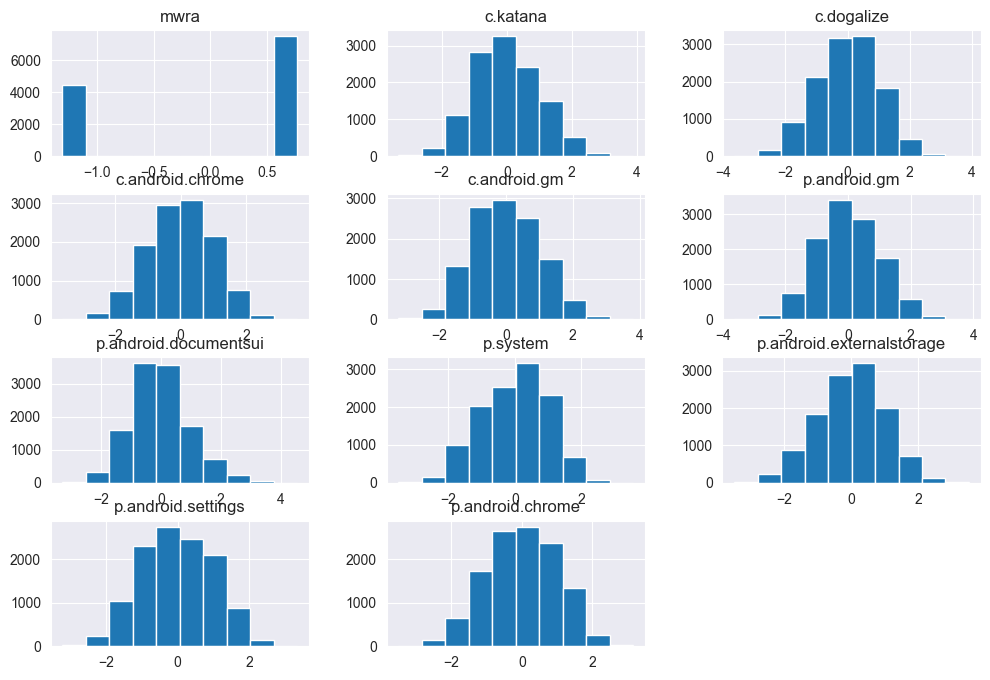

In [123]:
train_df.hist(column=train_df.columns[1:],figsize=(12,8))

##### Quantile Transformation

In [124]:
from sklearn.preprocessing import QuantileTransformer

print("Original Data Description:")
print(train_df.describe())

def quantile_transform(df):
    quantile_transformer = QuantileTransformer(output_distribution='normal')  
    train_df_quantile_transformed = quantile_transformer.fit_transform(df)
    return train_df_quantile_transformed

train_df = pd.DataFrame(train_df, columns=train_df.columns)

Original Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       0.000525     -0.004102      0.001062      0.003372   
std        1.000816      1.001132      0.998250      1.000722   
min       -1.048462     -1.303169     -3.331347     -3.648779   
25%       -0.896585     -1.303169     -0.722288     -0.694356   
50%       -0.074688      0.767360     -0.064663      0.038876   
75%        1.444075      0.767360      0.702402      0.714100   
max        1.444075      0.767360      3.882086      3.902603   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean          -0.002340      0.003796      0.003811               0.001673   
std            1.003534      0.999315      0.999314               0.997291   
min           -3.615476     -3.213357     -3.634722              -3.283088 

In [125]:
print("Transformed Data Description:")
print(train_df.describe())

Transformed Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       0.000525     -0.004102      0.001062      0.003372   
std        1.000816      1.001132      0.998250      1.000722   
min       -1.048462     -1.303169     -3.331347     -3.648779   
25%       -0.896585     -1.303169     -0.722288     -0.694356   
50%       -0.074688      0.767360     -0.064663      0.038876   
75%        1.444075      0.767360      0.702402      0.714100   
max        1.444075      0.767360      3.882086      3.902603   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean          -0.002340      0.003796      0.003811               0.001673   
std            1.003534      0.999315      0.999314               0.997291   
min           -3.615476     -3.213357     -3.634722              -3.2830

array([[<Axes: title={'center': 'mwra'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>],
       [<Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.chrome'}>, <Axes: >]],
      dtype=object)

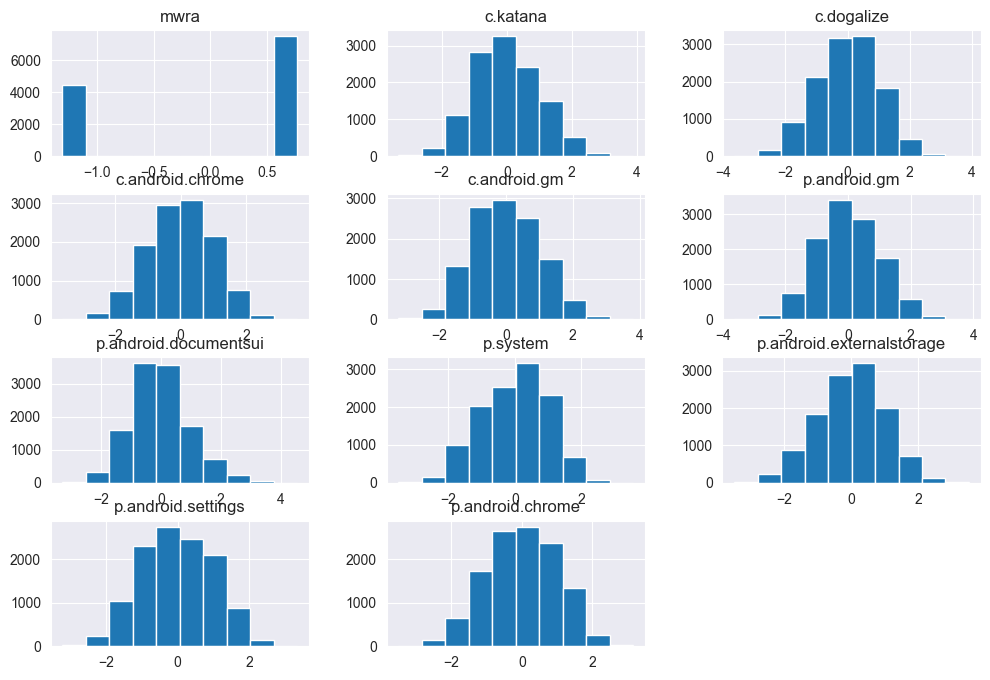

In [126]:
train_df.hist(column=train_df.columns[1:],figsize=(12,8))

#### Scaling

##### Standard Scaling

In [127]:
print(train_df.describe())
def standard_scale(df):
    scaler_standard = StandardScaler()
    train_df_standard_scaled = scaler_standard.fit_transform(df)
    
    # Shift the data to make all values non-negative
    train_df_standard_scaled_shifted = train_df_standard_scaled - np.min(train_df_standard_scaled)
    return train_df_standard_scaled_shifted

               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       0.000525     -0.004102      0.001062      0.003372   
std        1.000816      1.001132      0.998250      1.000722   
min       -1.048462     -1.303169     -3.331347     -3.648779   
25%       -0.896585     -1.303169     -0.722288     -0.694356   
50%       -0.074688      0.767360     -0.064663      0.038876   
75%        1.444075      0.767360      0.702402      0.714100   
max        1.444075      0.767360      3.882086      3.902603   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean          -0.002340      0.003796      0.003811               0.001673   
std            1.003534      0.999315      0.999314               0.997291   
min           -3.615476     -3.213357     -3.634722              -3.283088   
25%           -0.703448 

In [128]:
train_df = pd.DataFrame(standard_scale(train_df), columns=train_df.columns)


print("\nStardard Scaled")
print(train_df.describe())


Stardard Scaled
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       3.649669      3.649669      3.649669      3.649669   
std        1.000042      1.000042      1.000042      1.000042   
min        2.601494      2.352016      0.311278      0.000000   
25%        2.753252      2.352016      2.925021      2.952415   
50%        3.574514      4.420291      3.583827      3.685149   
75%        5.092102      4.420291      4.352268      4.359914   
max        5.092102      4.420291      7.537660      7.546250   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean           3.649669      3.649669      3.649669               3.649669   
std            1.000042      1.000042      1.000042               1.000042   
min            0.049105      0.430176      0.008486               0.355848   
25%    

array([[<Axes: title={'center': 'mwra'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>],
       [<Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.chrome'}>, <Axes: >]],
      dtype=object)

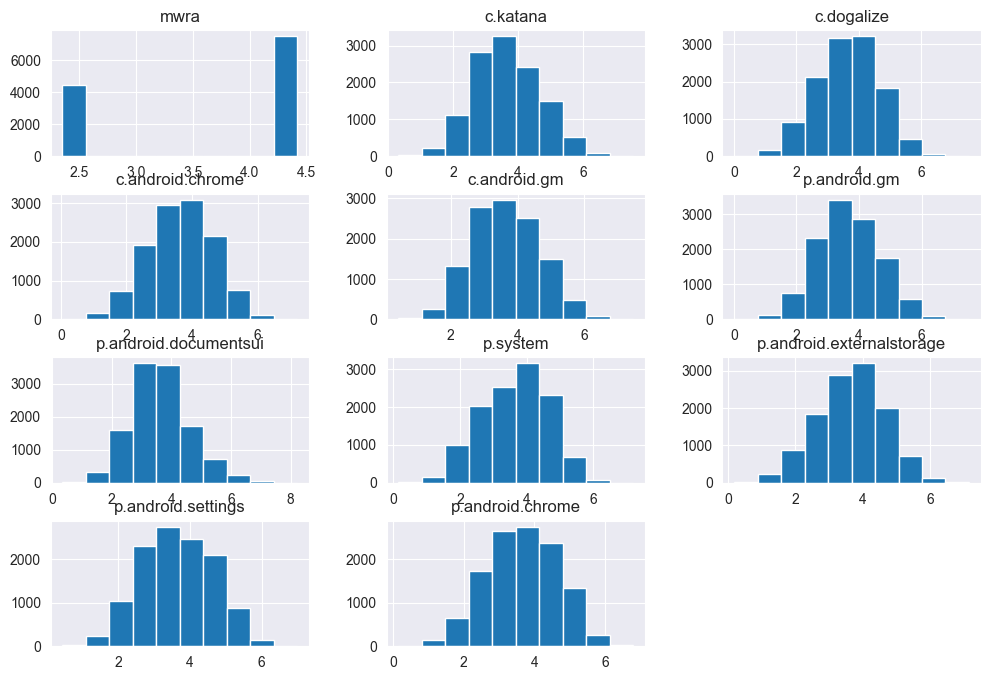

In [129]:
train_df.hist(column=train_df.columns[1:],figsize=(12,8))

##### Min-Max Scaling

In [130]:
from sklearn.preprocessing import MinMaxScaler
print(train_df.describe())

def min_max_scale(df):
    scaler_minmax = MinMaxScaler(feature_range=(0,5))
    train_df_minmax = scaler_minmax.fit_transform(df)
    return train_df_minmax 

               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       3.649669      3.649669      3.649669      3.649669   
std        1.000042      1.000042      1.000042      1.000042   
min        2.601494      2.352016      0.311278      0.000000   
25%        2.753252      2.352016      2.925021      2.952415   
50%        3.574514      4.420291      3.583827      3.685149   
75%        5.092102      4.420291      4.352268      4.359914   
max        5.092102      4.420291      7.537660      7.546250   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean           3.649669      3.649669      3.649669               3.649669   
std            1.000042      1.000042      1.000042               1.000042   
min            0.049105      0.430176      0.008486               0.355848   
25%            2.951001 

In [131]:
train_df = pd.DataFrame(min_max_scale(train_df), columns=train_df.columns)

print("\nMin-Max Scaled")
print(train_df.describe())


Min-Max Scaled
               imei          mwra      c.katana    c.dogalize  \
count  11938.000000  11938.000000  11938.000000  11938.000000   
mean       2.104256      3.137041      2.309863      2.418201   
std        2.007626      2.417575      0.691938      0.662609   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.304662      0.000000      1.808473      1.956213   
50%        1.953378      5.000000      2.264306      2.441709   
75%        5.000000      5.000000      2.795998      2.888795   
max        5.000000      5.000000      5.000000      5.000000   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11938.000000  11938.000000  11938.000000           11938.000000   
mean           2.514050      2.290474      2.426781               2.094436   
std            0.698267      0.711469      0.666509               0.635895   
min            0.000000      0.000000      0.000000               0.000000   
25%     

array([[<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.android.chrome'}>, <Axes: >, <Axes: >]],
      dtype=object)

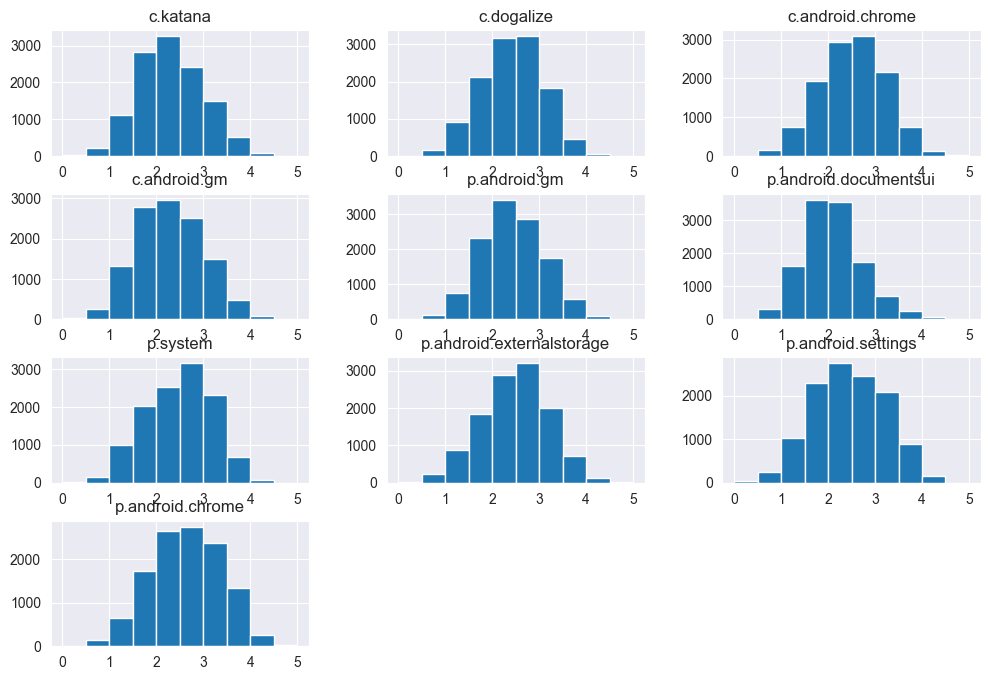

In [132]:
train_df.hist(column=train_df.columns.drop(["imei", "mwra"]), figsize=(12, 8))

## 2.2 Výber atribútov pre strojové učenie

### A/C - Zisťujeme, ktoré atribúty sú pre ML informatívne k predikovanej premennej + zdôvodnenie

#### RFE - je iteratívna metóda výberu atribútov, ktorá postupne odstraňuje najmenej dôležité atribúty na základe ich prínosu (ich vplyv na model) pre model. Vybrali sme ju, pretože umožňuje identifikovať atribúty, ktoré majú najsilnejší vplyv na predikciu

In [133]:
def get_top_rfe(X, y):

    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=4, step=1)
    selector.fit(X, y)

    features = X.columns[selector.support_].tolist()
    return features

X = train_df.drop(columns=['mwra'])
y = train_df['mwra']

features1 = get_top_rfe(X, y)
print(features1)

['c.katana', 'c.android.chrome', 'c.android.gm', 'p.android.gm']


#### Korelačná analýza - základná metóda, pomocou ktorej sme identifikovali lineárne vzťahy medzi atribútmi a mwra. Potrebná na zistenie, ktoré atribúty sú silno lineárne prepojené s mwra. Vybrali sme si ju kôli jednoduchosti a vhodnosti pre náš model.

In [134]:
def get_top_correlations(the_df):
    numerical_columns = the_df.select_dtypes(include=[np.number])
    correlation_matrix = numerical_columns.corr()
    
    target_correlations = correlation_matrix["mwra"].drop("mwra")
    features = target_correlations.abs().sort_values(ascending=False).head(4)
    
    return features.index.tolist()

features2 = get_top_correlations(train_df)
print(features2)

['c.katana', 'c.android.chrome', 'p.android.gm', 'p.android.documentsui']


#### Mutual info - použitá na meranie množstva informácií, ktoré jeden atribút poskytuje o mrwa. Použili sme ju aj preto, pretože zachytáva aj nelineárne vzťahy medzi premennými, čiže veľmi jedinečné informácie, ktoré niesú lineárne závislé

In [135]:
def get_top_mutual_info(X, y):
    selector = mutual_info_regression(X, y)
    scores = pd.Series(selector, index=X.columns)
    top_features = scores.nlargest(4)
    return top_features.index.tolist()

X = train_df.drop('mwra', axis=1)
y = train_df['mwra']

features3 = get_top_mutual_info(X, y)
print(features3)


['c.katana', 'c.android.chrome', 'p.android.gm', 'p.android.documentsui']


In [136]:
from sklearn.ensemble import RandomForestRegressor

def get_top_feature_importance(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    return pd.Series(importances, index=X.columns).nlargest(4).index.tolist()

### B/C - zoradenie atribútov + zdôvodnenie

#### Na základe analýzy sme identifikovali najrelevantnejšie atribúty ovplyvňujúce mwra:
1. c.katana
2. c.android.chrome
3. p.android.gm
#### usporiadali sme tieto atribúty v takomto poradí a to na základe výsledkov z predošlích testov, keďže RFE podľa modelu SVR s lineárnym jadromnajlepšie predpovedá tieto atribúty:
['c.katana', 'c.android.chrome', 'c.android.gm', 'p.android.gm']
#### podobne predpovedala aj korelačná závislosť, no rozdiel bol len v jednom atribúte,
['c.katana', 'c.android.chrome', 'p.android.gm', 'p.system']
#### pri mutual information, ktorá sa zameriava na to, koľko informáacií poskytuje každý atribút o mrwa, zistili sme, že najvplyvňejšie atribúty sú:
['c.katana', 'c.android.chrome', 'p.android.gm', 'p.android.settings']

## 2.3 Replikovateľnosť predspracovania

### A/B

#### všetky úpravy dát sú robené vo funkciách, ktoré sú aplikovateľné aj pre ďalšie použitie

In [137]:
test_df = test_df.drop(['ts'], axis=1)

test_df = remove_outliers_from_dataframe(test_df)

test_df = handle_missing_values(test_df)

test_df = normalize_data(test_df)

test_df = remove_duplicates(test_df)

test_df_power_transformed = power_transform(test_df)

test_df_quantile_transformed = quantile_transform(test_df)

print(train_df.dtypes)

test_df.to_csv("test_data.csv")


imei                         float64
mwra                         float64
c.katana                     float64
c.dogalize                   float64
c.android.chrome             float64
c.android.gm                 float64
p.android.gm                 float64
p.android.documentsui        float64
p.system                     float64
p.android.externalstorage    float64
p.android.settings           float64
p.android.chrome             float64
dtype: object


### 50/50